In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Exploratory data analysis

In [10]:
from synbio_morpher.utils.results.analytics.timeseries import calculate_adaptation
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from evoscaper.utils.preprocess import make_datetime_str
from evoscaper.utils.evolution import calculate_ruggedness_from_perturbations
import sys
import numpy as np
from functools import partial
import jax.numpy as jnp
import jax
import itertools
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import umap
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import plotly.express as px

In [11]:
top_write_dir = os.path.join('data', '10_eda', make_datetime_str())
os.makedirs(top_write_dir, exist_ok=True)

In [12]:
# fn = '../data/raw/summarise_simulation/2024_11_21_144918/tabulated_mutation_info.csv'
# fn = '../data/raw/summarise_simulation/2024_11_21_160955/tabulated_mutation_info.csv'
fn = '../data/raw/summarise_simulation/2024_12_05_210221/tabulated_mutation_info.csv'
# fn_sim = './data/simulate_circuits/2025_01_29__18_12_38/tabulated_mutation_info.json'
# fn_sim = 'data/simulate_circuits/2025_02_01__00_22_38/tabulated_mutation_info.json'
fn_sim = './data/simulate_circuits/2025_02_11__13_56_51/tabulated_mutation_info.json'

dir_ruggedness = 'data/07_ruggedness/2025_02_07__15_33_55'
ruggedness = np.load(os.path.join(dir_ruggedness, 'ruggedness.npy'))
analytics = load_json_as_dict(os.path.join(dir_ruggedness, 'analytics.json'))
resimulate_analytics = True

# fn_test_data = '../data/raw/summarise_simulation/2023_07_17_222747/tabulated_mutation_info.csv'
# data = pd.concat([pd.read_csv(fn), pd.read_csv(fn_test_data)])
data = pd.read_json(fn) if fn.endswith('.json') else pd.read_csv(fn)
data_sim = pd.read_json(fn_sim) if fn_sim.endswith('.json') else pd.read_csv(fn_sim)
len(data)

600000

In [18]:
# from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict, write_json

rn = {'sensitivity_wrt_species-6': 'sensitivity',
      'precision_wrt_species-6': 'precision',
      'response_time_wrt_species-6': 'response_time'}

for k, v in rn.items():
    if k in analytics:
        print('renaming', k, 'to', v)
        analytics[v] = analytics.pop(k)
# analytics = write_json(analytics, os.path.join(dir_ruggedness, 'analytics.json'), overwrite=True)


renaming sensitivity_wrt_species-6 to sensitivity
renaming precision_wrt_species-6 to precision
renaming response_time_wrt_species-6 to response_time


In [19]:
resimulate_analytics = True
objective_col = 'Log sensitivity'
output_species = ['RNA_2']
cols_e = get_true_interaction_cols(data, 'energies', remove_symmetrical=True)
n_interactions = len(cols_e)
filt = data['sample_name'].isin(output_species)
output_idx = -1

analytic_perturbed = np.array(analytics[objective_col])
analytic_perturbed = analytic_perturbed.reshape(
    -1, n_interactions + resimulate_analytics, ruggedness.shape[-1])


def split_pert_og(pert):
    return pert[:, -1], pert[:, :-1]


if resimulate_analytics:
    analytic_og, analytic_perturbed = split_pert_og(analytic_perturbed)
else:
    analytic_og = data[objective_col].values

In [20]:
analytics['adaptation'] = calculate_adaptation(
    np.array(analytics['sensitivity']), np.array(analytics['precision']))

og_sensitivity, pert_sensitivity = split_pert_og(np.array(analytics['Log sensitivity']).reshape(
    -1, n_interactions + resimulate_analytics, ruggedness.shape[-1]))
og_precision, pert_precision = split_pert_og(np.array(analytics['Log precision']).reshape(
    -1, n_interactions + resimulate_analytics, ruggedness.shape[-1]))
og_adaptation, pert_adaptation = split_pert_og(np.array(analytics['adaptation']).reshape(
    -1, n_interactions + resimulate_analytics, ruggedness.shape[-1]))
og_overshoot, pert_overshoot = split_pert_og(np.array(analytics['overshoot']).reshape(
    -1, n_interactions + resimulate_analytics, ruggedness.shape[-1]))
og_resptime, pert_resptime = split_pert_og(np.array(analytics['response_time']).reshape(
    -1, n_interactions + resimulate_analytics, ruggedness.shape[-1]))

eps_perc = - 1e-2
eps = eps_perc * np.abs(data[cols_e].to_numpy()).max()

ruggedness_adaptation = jax.vmap(partial(calculate_ruggedness_from_perturbations, eps=eps))(
    pert_adaptation, og_adaptation[:, None, :])

In [21]:
data_seq = pd.DataFrame()

for k, v in analytics.items():
    og_k, pert_k = split_pert_og(np.array(v).reshape(
        -1, n_interactions + resimulate_analytics, ruggedness.shape[-1]))
    data_seq[k] = og_k[..., output_idx]
    
# data_seq['ruggedness_adaptation'] = ruggedness_adaptation[..., output_idx]
# data_seq['ruggedness_sensitivity'] = ruggedness[..., output_idx]

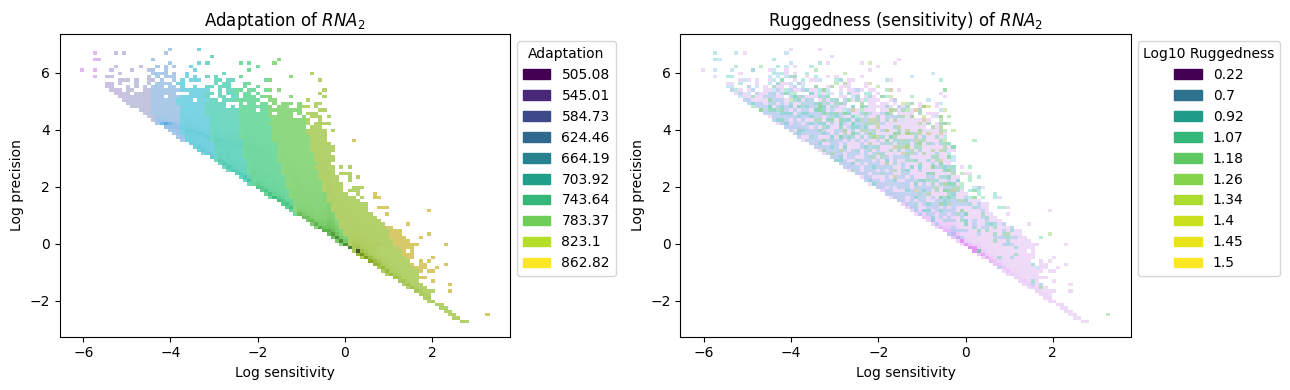

In [22]:
df = pd.DataFrame()
for k, v in zip(['Log sensitivity', 'Log precision', 'adaptation', 'response_time', 'ruggedness_adaptation', 'ruggedness_sensitivity', 'overshoot'], 
                [og_sensitivity, og_precision, og_adaptation, og_resptime, ruggedness_adaptation, ruggedness, og_overshoot]):
    df[k] = v[..., output_idx]
filt_df = ~df['Log sensitivity'].isna() & ~np.isinf(df['Log sensitivity']) & ~np.isinf(df['adaptation']) & (df['overshoot'] > 0) #& (df['response_time'] < 0.8*df['response_time'].max())
df = df[filt_df]
df['adaptation_bin'] = pd.cut(df['adaptation'], bins=10)
df['Adaptation'] = df['adaptation_bin'].apply(lambda x: x.mid).astype(np.float32).apply(lambda x: np.round(x, 2))
df['ruggedness_adaptation_bin'] = pd.cut(df['ruggedness_adaptation'], bins=10)
df['ruggedness_sensitivity_bin'] = pd.cut(df['ruggedness_sensitivity'], bins=10)
df['ruggedness_sensitivity_bins'] = df['ruggedness_sensitivity_bin'].apply(lambda x: x.mid).astype(np.float32)
df['Log10 Ruggedness'] = df['ruggedness_sensitivity_bins'].apply(np.log10).apply(lambda x: np.round(x, 2))

fig, axs = plt.subplots(1, 2, figsize=(13, 4))
g = sns.histplot(df, x='Log sensitivity', y='Log precision', hue='Adaptation', palette='viridis', ax=axs[0])
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
axs[0].set_title(f'Adaptation of $RNA_2$')

# g = sns.scatterplot(df, x='Log sensitivity', y='Log precision', hue='ruggedness_sensitivity', palette='viridis', ax=axs[1], alpha=0.1)
g = sns.histplot(df, x='Log sensitivity', y='Log precision', hue='Log10 Ruggedness', palette='viridis', ax=axs[1], alpha=0.5)
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
axs[1].set_title(f'Ruggedness (sensitivity) of $RNA_2$')

plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'scatter_sp_rugged.png'), dpi=300, transparent=True)

In [23]:
# data['Log sensitivity'] = np.log10(data['sensitivity'])
# data['Log precision'] = np.log10(data['precision'])
# data['adaptation'] = calculate_adaptation(data['sensitivity'].to_numpy(), data['precision'].to_numpy())
# data['adaptation_bin'] = pd.cut(data['adaptation'], bins=10)
# data['adaptation_bins'] = data['adaptation_bin'].apply(lambda x: x.mid).astype(float)
# filt = (data['sample_name'] == 'RNA_2') & (data['response_time'] < 0.8*data['response_time'].max())
# # data['response_time_bin'] = pd.cut(data['response_time'], bins=10)
# # data['response_time_bins'] = data['response_time_bin'].apply(lambda x: x.mid).astype(float)

# fig, axs = plt.subplots(1, 2, figsize=(12, 4))
# g = sns.histplot(data[filt], x='Log sensitivity', y='Log precision', hue='adaptation_bin', palette='viridis', ax=axs[0])
# sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
# axs[0].set_title('Adaptation of RNA_2')

# g = sns.histplot(data[filt], x='Log sensitivity', y='Log precision', hue='adaptation_bin', palette='viridis', ax=axs[1])
# sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
# axs[1].set_title('Ruggedness of RNA_2')

# plt.tight_layout()

/tmp/ipykernel_2900517/1577871673.py:10: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data_seq[filt_seq], x='Log10 Sensitivity', y='Log10 Precision', palette='viridis', bins=200, ax=axs[0])
/tmp/ipykernel_2900517/1577871673.py:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data_sim[filt_sim], x='Log10 Sensitivity', y='Log10 Precision', palette='viridis', bins=200, ax=axs[1])


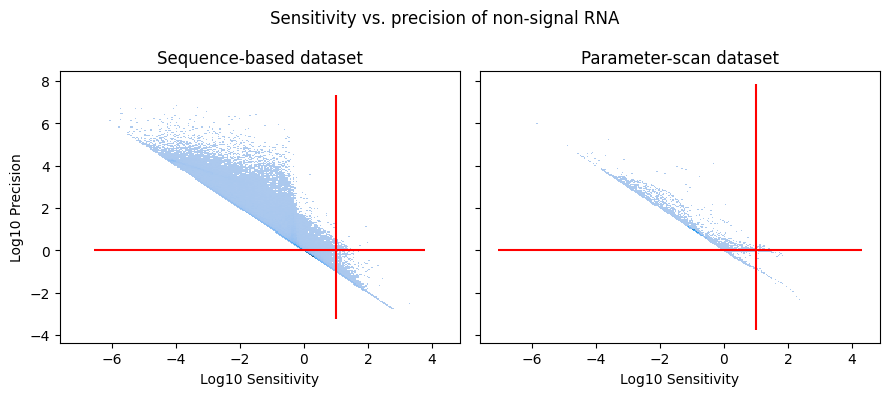

In [24]:
# filt_seq = data['sample_name'].isin(['RNA_1', 'RNA_2']) & (data['overshoot'] > 0) #& (data['response_time'] < 0.9 * data['response_time'].max())
filt_seq = (data_seq['overshoot'] > 0)
filt_sim = (data_sim['sample_name'] == 'RNA_2') & (data_sim['overshoot'] > 0)
data_seq['Log10 Sensitivity'] = np.log10(data_seq['sensitivity'])
data_seq['Log10 Precision'] = np.log10(data_seq['precision'])
data_sim['Log10 Sensitivity'] = np.log10(data_sim['sensitivity'])
data_sim['Log10 Precision'] = np.log10(data_sim['precision'])

fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharex=True, sharey=True)
sns.histplot(data_seq[filt_seq], x='Log10 Sensitivity', y='Log10 Precision', palette='viridis', bins=200, ax=axs[0])
axs[0].hlines(0, *axs[0].get_xlim(), color='r')
axs[0].vlines(1, *axs[0].get_ylim(), color='r')
axs[0].set_title('Sequence-based dataset')
sns.histplot(data_sim[filt_sim], x='Log10 Sensitivity', y='Log10 Precision', palette='viridis', bins=200, ax=axs[1])
axs[1].hlines(0, *axs[1].get_xlim(), color='r')
axs[1].vlines(1, *axs[1].get_ylim(), color='r')
axs[1].set_title('Parameter-scan dataset')

plt.suptitle('Sensitivity vs. precision of non-signal RNA')

plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'scatter_sp_ogdata.png'), dpi=300, transparent=True)

In [25]:
exclude_cols = ['RMSE', 'num_interacting', 'num_self_interacting', 'circuit_name']
numerical_columns = data[data.columns.difference(exclude_cols)].select_dtypes(include=[np.number]).columns.tolist()
len(numerical_columns)

53

In [27]:
if 'Log sensitivity' not in data.columns:
    data['Log sensitivity'] = np.where(np.isinf(np.log10(data['sensitivity'])), np.nan, np.log10(data['sensitivity']))
if 'Log precision' not in data.columns:
    data['Log precision'] = np.where(np.isinf(np.log10(data['precision'])), np.nan, np.log10(data['precision']))
    
data['Log sensitivity bin'] = pd.cut(data['Log sensitivity'], bins=10)
data['Log sensitivity bin'] = data['Log sensitivity bin'].apply(lambda x: np.round(x.mid, 1)).astype(float)

combos_e = list(itertools.combinations(cols_e, 2))
filt_d = (data['sample_name'] == 'RNA_2') & (data['Log sensitivity'] > -5) & (data['Log sensitivity'] < 3) & (~data['Log precision'].isna())


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Ruggedness

# Motifs

In [28]:
# nrows = len(cols_e)
# cols = len(cols_e)
# fig, axes = plt.subplots(nrows, cols, figsize=(3*cols, 2*nrows))
# for i, (k1, k2) in enumerate(combos_e):
#     ax = axes[cols_e.index(k1), cols_e.index(k2)]
#     sns.histplot(data[filt], x=k1, y=k2, hue='Log sensitivity bin', palette='viridis', ax=ax, legend=False if i < len(combos_e) - 1 else True, alpha=0.5)
#     if ax.get_legend() is not None:
#         sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
# plt.tight_layout()

In [39]:
def latin_hypercube_sampling(num_params, param_bounds, num_samples=1000):
    samples = np.zeros((num_samples, num_params))
    for i, (lower, upper) in enumerate(param_bounds):
        samples[:, i] = np.random.uniform(lower, upper, num_samples)
    
    # Shuffle to ensure stratified sampling
    for j in range(num_params):
        np.random.shuffle(samples[:, j])
    
    return samples

def reduce_dimensionality(df, n_components=2):
    X = df.values
    
    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Apply UMAP
    reducer = umap.UMAP(n_components=n_components,
                        n_neighbors=30,
                        init='pca',
                        min_dist=0.1)
    X_reduced = reducer.fit_transform(X_scaled)
    
    # Add reduced coordinates to original DataFrame
    df['UMAP_1'] = X_reduced[:, 0]
    df['UMAP_2'] = X_reduced[:, 1]
    
    return df

def cluster_parameter_groups(df, eps=0.5, cols=['UMAP_1', 'UMAP_2'], min_samples=5):
    clusterer = DBSCAN(eps=eps, min_samples=min_samples)
    df['cluster'] = clusterer.fit_predict(df[cols])
    
    return df

def visualize_results(df, hue='cluster'):
    fig = px.scatter(
        df, 
        x='UMAP_1', 
        y='UMAP_2', 
        color=hue, 
        hover_data=[col for col in df.columns if col.startswith('param_')],
        title='Parameter Space Exploration'
    )
    # Set square dimensions and adjust layout
    fig.update_layout(
        width=600,  # Equal width and height
        height=600,
        plot_bgcolor='white',
        paper_bgcolor='white',
        margin=dict(l=50, r=50, t=50, b=50)
    )
    return fig

# Create and run analysis
filt_d = (data['sample_name'] == 'RNA_2') & (data['Log sensitivity'] > -5) & (data['Log sensitivity'] < 3) & (~data['Log precision'].isna())
# filt_d = filt_d & (data['Log sensitivity'] > 1)
results = data[filt_d][cols_e] #.iloc[:10000]
# results = data[filt_d][cols_e + ['Log sensitivity', 'Log precision', 'overshoot']].iloc[:10000]
reduced_results = reduce_dimensionality(results)
clustered_results = cluster_parameter_groups(reduced_results, min_samples=100)
# visualization = visualize_results(clustered_results)
# visualization.show()

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [40]:
clustered_results['Log sensitivity'] = data[filt_d]['Log sensitivity']

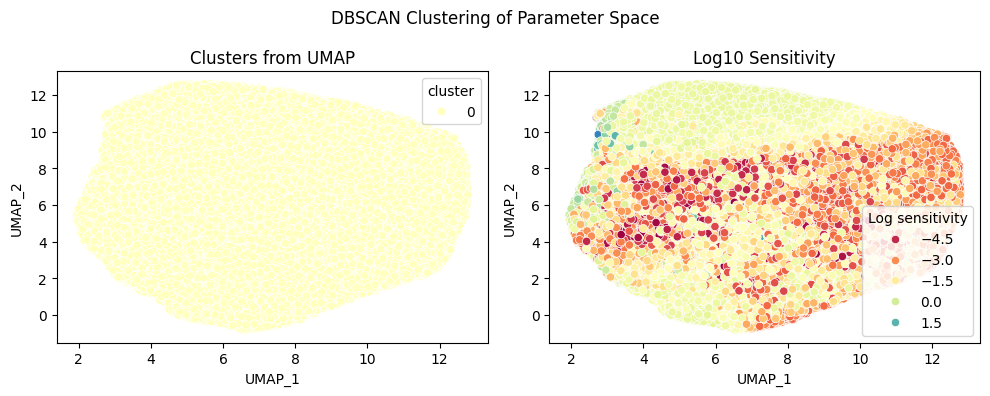

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
sns.scatterplot(clustered_results, x='UMAP_1', y='UMAP_2', hue='cluster', palette='Spectral', ax=axs[0])
axs[0].set_title('Clusters from UMAP')
sns.scatterplot(clustered_results, x='UMAP_1', y='UMAP_2', hue='Log sensitivity', palette='Spectral', ax=axs[1])
axs[1].set_title('Log10 Sensitivity')
plt.suptitle('DBSCAN Clustering of Parameter Space')
plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'scatter_umap_clusters.png'), dpi=300, transparent=True)


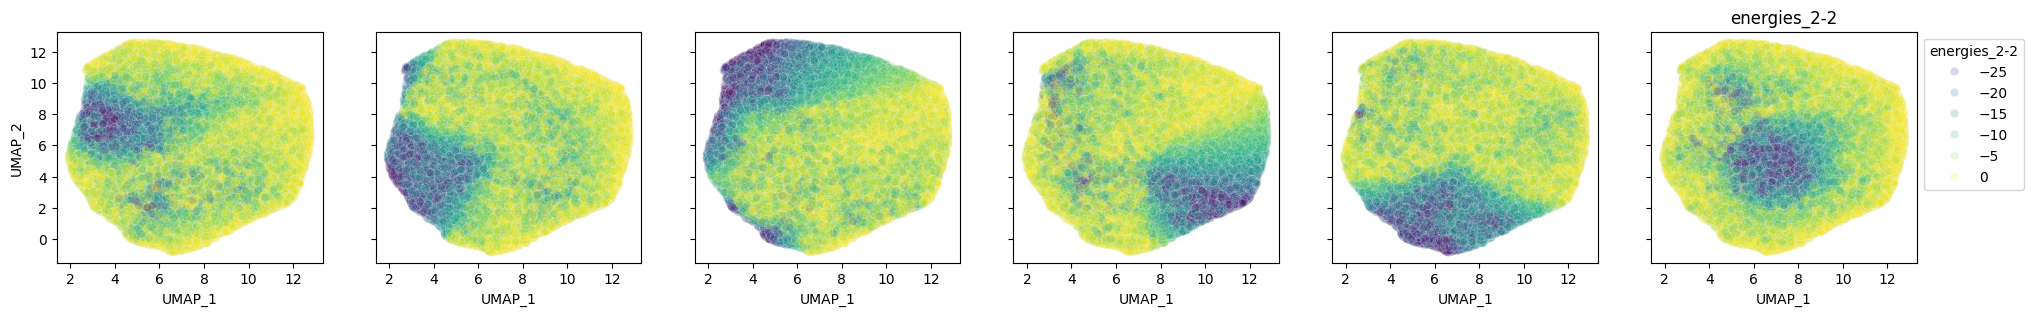

In [43]:
clusters = sorted(clustered_results['cluster'].unique())
nrows = len(clusters)
ncols = len(cols_e)
fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), sharex=True, sharey=True)
if nrows == 1:
    axs = axs[None, :]
for ic, cluster in enumerate(clusters):
    for i, e_col in enumerate(cols_e):
        sns.scatterplot(clustered_results[clustered_results['cluster'] == cluster], x='UMAP_1', y='UMAP_2', hue=e_col, palette='viridis', alpha=0.2, ax=axs[ic, i], legend=False if i < len(cols_e) - 1 else True)
        if ic == 0:
            plt.title(e_col)
        if axs[ic, i].get_legend() is not None:
            sns.move_legend(axs[ic, i], 'upper left', bbox_to_anchor=(1, 1))

In [ ]:
# clusters = sorted(clustered_results['cluster'].unique())
# nrows = int(np.ceil(np.sqrt(len(clusters))))
# ncols = int(np.ceil(np.sqrt(len(clusters))))
# fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows))
# for i, cluster in enumerate(clusters):
#     ax = axes.flatten()[i]
#     filt = clustered_results['cluster'] == cluster
#     sns.histplot(clustered_results[filt], x='Log sensitivity', y='Log precision', ax=ax)
#     ax.set_xlim(clustered_results['Log sensitivity'].min(), clustered_results['Log sensitivity'].max())
#     ax.set_ylim(clustered_results['Log precision'].min(), clustered_results['Log precision'].max())
#     ax.set_title(f'Cluster {cluster}')
# plt.tight_layout()

In [ ]:
# nrows = len(cols_e)
# cols = len(cols_e)
# fig, axes = plt.subplots(nrows, cols, figsize=(3*cols, 2*nrows))
# for i, (k1, k2) in enumerate(combos_e):
#     ax = axes[cols_e.index(k1), cols_e.index(k2)]
#     c_i = clustered_results[clustered_results['cluster'] == 14]
#     sns.histplot(c_i, x=k1, y=k2, hue='cluster', palette='viridis', ax=ax, legend=False if i < len(combos_e) - 1 else True, alpha=0.5)
#     if ax.get_legend() is not None:
#         sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
# plt.tight_layout()